<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/VGG16_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [40]:
# Standard library imports
import os
import ast

# Third-party general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from PIL import Image

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Additional Keras imports
from keras.utils import to_categorical

# Imports from Google Colab
from google.colab import files

# Access Dataset via Kaggle API


In [2]:

uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
 99% 1.61G/1.62G [00:13<00:00, 141MB/s]
100% 1.62G/1.62G [00:13<00:00, 127MB/s]


# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

# Splitting the Data

In [4]:
# Splitting the dataset into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Data Distribution
- Class Distribution of Train, Test and Validation Data - all three sets portray the class imbalance represented by Myopia, Hypertension, AMD, Cataract and Glaucoma.

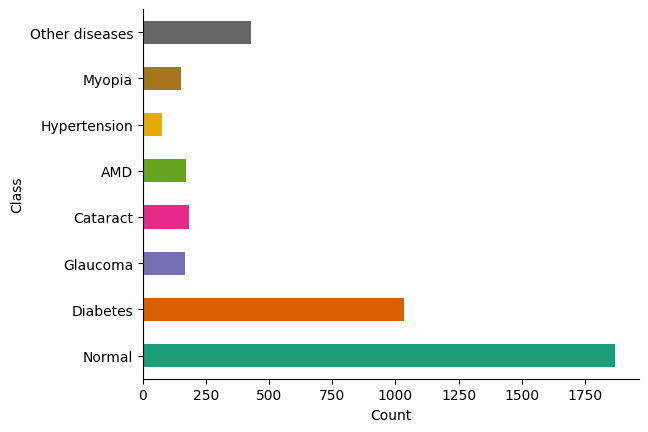

In [5]:
# @title Distribution of Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

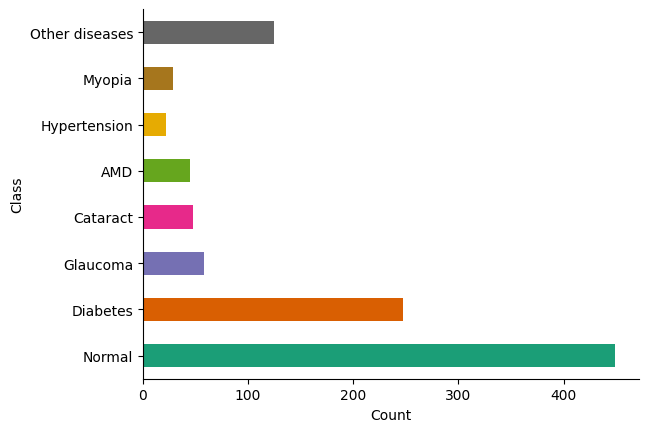

In [6]:
# @title Distribution of Validation Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
val_df['class_name'] = val_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = val_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

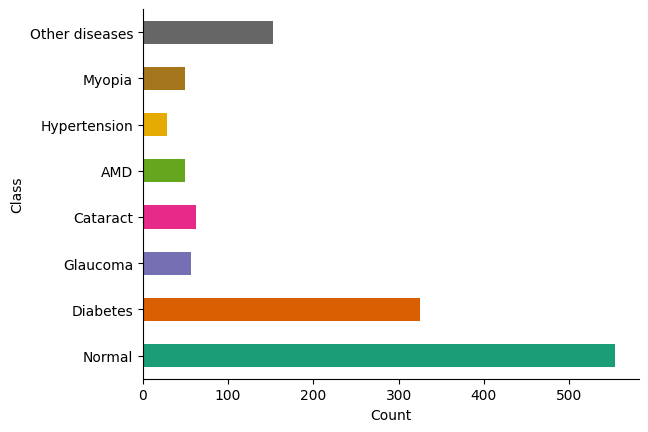

In [7]:
# @title Distribution of Test Data
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])

class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# Data Preparation

##Apply random sampling
- A combination of oversampling and undersampling applied to the data.
- The idea is to balance the data by oversampling the minority class and then undersampling the majority class.


In [8]:

class_distribution = train_df['target'].value_counts()


# Set minimum and maximum thresholds
min_threshold = int(class_distribution.max() * 0.5)  # minimum is half of the largest class size
max_threshold = int(class_distribution.max() * 0.8)  # maximum is 80% of the largest class size

# Determine target samples per class based on conditions
n_samples_per_class = {
    label: max(min_threshold, min(len(df_class), max_threshold)) for label, df_class in train_df.groupby('target')
}

print("Number of samples per class to resample to:", n_samples_per_class)

df_resampled = pd.DataFrame(columns=train_df.columns)

# Upsample or downsample each class according to the specified logic
for class_label, target_count in n_samples_per_class.items():
    df_class = train_df[train_df['target'] == class_label]

    if not df_class.empty:
        # Resample each class to the target count
        df_class_resampled = resample(df_class,
                                      replace=len(df_class) < target_count,  # Sample with replacement if upsampling
                                      n_samples=target_count,  # Target count determined by the logic above
                                      random_state=123)  # For reproducibility
        df_resampled = pd.concat([df_resampled, df_class_resampled])
    else:
        print(f"No samples for class {class_label}. Check your data.")

df_resampled = df_resampled.sample(frac=1, random_state=123).reset_index(drop=True)

Number of samples per class to resample to: {'[0, 0, 0, 0, 0, 0, 0, 1]': 935, '[0, 0, 0, 0, 0, 0, 1, 0]': 935, '[0, 0, 0, 0, 0, 1, 0, 0]': 935, '[0, 0, 0, 0, 1, 0, 0, 0]': 935, '[0, 0, 0, 1, 0, 0, 0, 0]': 935, '[0, 0, 1, 0, 0, 0, 0, 0]': 935, '[0, 1, 0, 0, 0, 0, 0, 0]': 1036, '[1, 0, 0, 0, 0, 0, 0, 0]': 1496}


**Class distribution before sampling**

In [9]:
class_distribution = train_df['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1870
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 0, 1]     430
[0, 0, 0, 1, 0, 0, 0, 0]     183
[0, 0, 0, 0, 1, 0, 0, 0]     171
[0, 0, 1, 0, 0, 0, 0, 0]     169
[0, 0, 0, 0, 0, 0, 1, 0]     153
[0, 0, 0, 0, 0, 1, 0, 0]      78
Name: count, dtype: int64


**Class Distribution after sampling**

In [10]:
class_distribution = df_resampled['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1496
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 1, 0]     935
[0, 0, 0, 0, 0, 1, 0, 0]     935
[0, 0, 0, 0, 1, 0, 0, 0]     935
[0, 0, 0, 0, 0, 0, 0, 1]     935
[0, 0, 1, 0, 0, 0, 0, 0]     935
[0, 0, 0, 1, 0, 0, 0, 0]     935
Name: count, dtype: int64


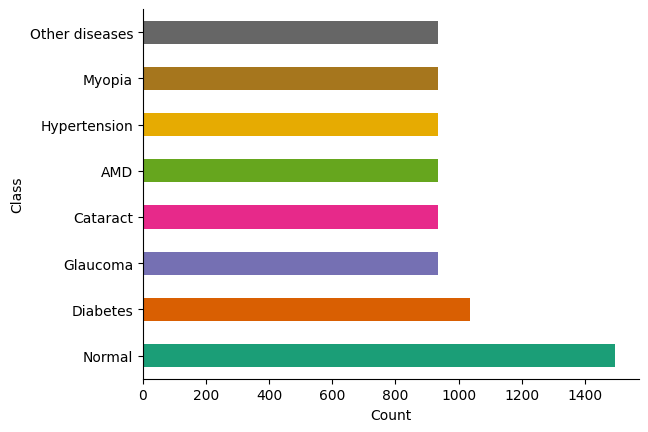

In [11]:
# @title Distribution of Sampled Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_resampled['class_name'] = df_resampled['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_resampled['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

##Image Preprocessing

In [12]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg16.preprocess_input(image)  # Preprocessing the image to be compatible with pretrained model
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

Preparing Train, Test and Validation Datasets

In [13]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset


In [14]:
train_ds = load_and_prepare_dataset(df_resampled, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=32)
test_ds = load_and_prepare_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=32)
val_ds = load_and_prepare_dataset(val_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=32)

Size of Datasets

In [15]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  509
size of validation dataset:  64
size of testing dataset:  80


# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


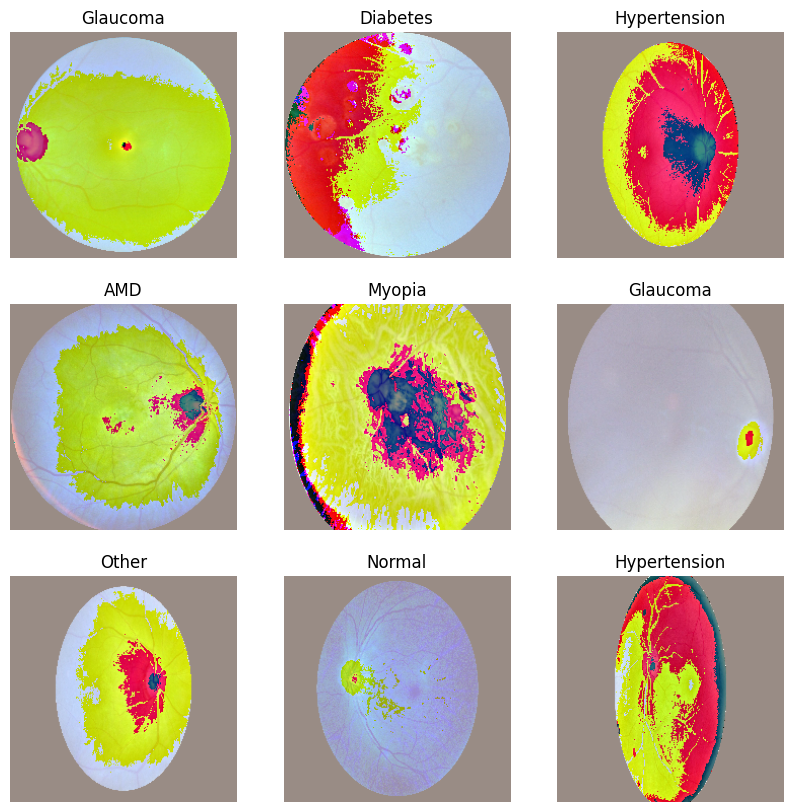

In [16]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


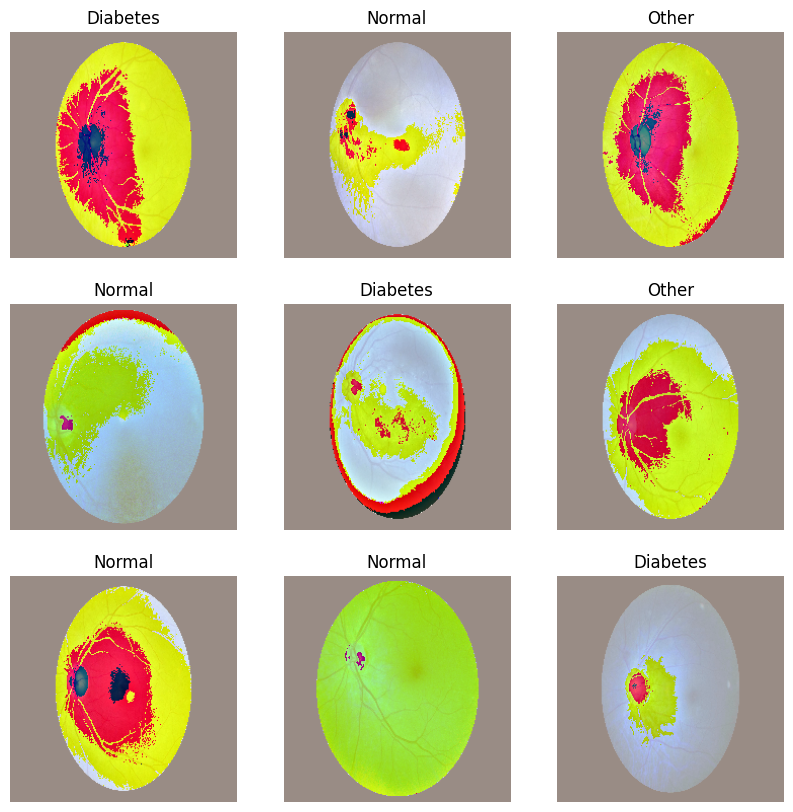

In [17]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

In [18]:

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [19]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 14981448 (57.15 MB)
Trainable params: 266760 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


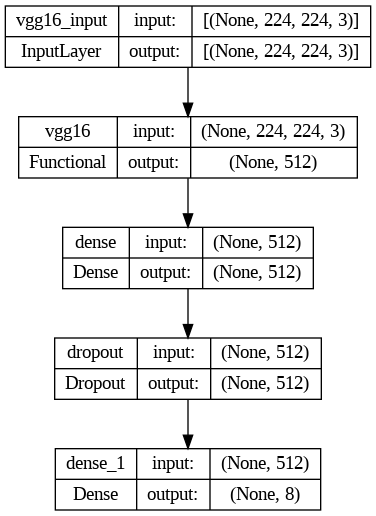

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
epochs = 80
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/80
509/509 [==============================] - ETA: 0s - loss: 2.5635 - accuracy: 0.3559
Epoch 1: val_loss improved from inf to 2.12554, saving model to best_model
509/509 [==============================] - 103s 126ms/step - loss: 2.5635 - accuracy: 0.3559 - val_loss: 2.1255 - val_accuracy: 0.3685 - lr: 1.0000e-04
Epoch 2/80
509/509 [==============================] - ETA: 0s - loss: 1.7803 - accuracy: 0.5165
Epoch 2: val_loss improved from 2.12554 to 1.88360, saving model to best_model
509/509 [==============================] - 87s 112ms/step - loss: 1.7803 - accuracy: 0.5165 - val_loss: 1.8836 - val_accuracy: 0.4477 - lr: 1.0000e-04
Epoch 3/80
509/509 [==============================] - ETA: 0s - loss: 1.5375 - accuracy: 0.5831
Epoch 3: val_loss improved from 1.88360 to 1.87607, saving model to best_model
509/509 [==============================] - 88s 112ms/step - loss: 1.5375 - accuracy: 0.5831 - val_loss: 1.8761 - val_accuracy: 0.4453 - lr: 1.0000e-04
Epoch 4/80
509/509 [=====

# Evaluating Model
- Model Accuracy
- Model Loss


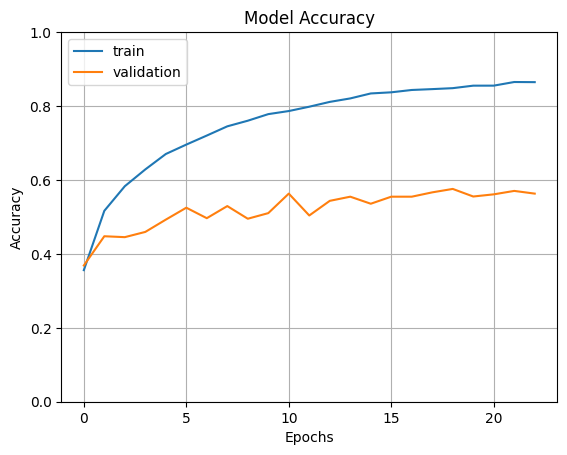

In [24]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

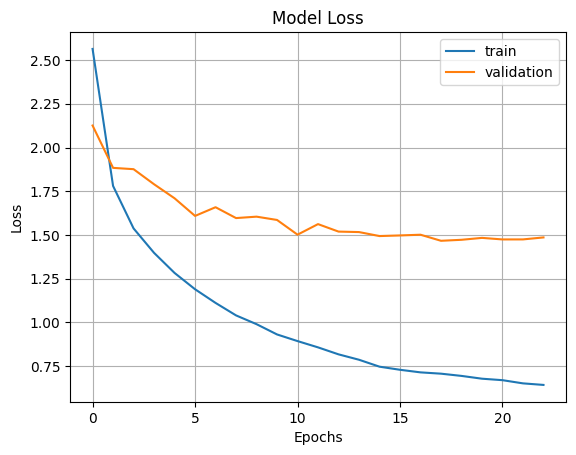

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Finetuning

In [26]:
# dictionary to store training history
full_history = {}

# Function to unfreeze layers gradually 1-4
def unfreeze_model(model, pretrained_model, n_layers):
    # Unfreeze the top `n_layers` of the pretrained model
    for layer in pretrained_model.layers[-n_layers:]:
        layer.trainable = True

    # Recompile the model every time change is made to layer's `trainable` status
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Gradually unfreeze the layers and save history
for i in range(1, 5):  #  unfreeze the top 4 layers one by one
    print(f"Unfreezing top {i} layers and retraining.")
    unfreeze_model(model, pretrained_model, i)

    history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

    # Save the history in the full_history dictionary
    full_history[f'phase_{i}'] = history.history

    # Save the model at each phase
    model.save(f'model_after_unfreezing_{i}_layers.h5')


Unfreezing top 1 layers and retraining.
Epoch 1/10
509/509 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.8560
Epoch 1: val_loss did not improve from 1.46674
509/509 [==============================] - 87s 109ms/step - loss: 0.6813 - accuracy: 0.8560 - val_loss: 1.4814 - val_accuracy: 0.5606 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.8553
Epoch 2: val_loss did not improve from 1.46674
509/509 [==============================] - 86s 109ms/step - loss: 0.6797 - accuracy: 0.8553 - val_loss: 1.4676 - val_accuracy: 0.5704 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.8605
Epoch 3: val_loss did not improve from 1.46674
509/509 [==============================] - 86s 109ms/step - loss: 0.6715 - accuracy: 0.8605 - val_loss: 1.4816 - val_accuracy: 0.5626 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.6697 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.8596
Epoch 1: val_loss did not improve from 1.46674
509/509 [==============================] - 87s 109ms/step - loss: 0.6745 - accuracy: 0.8596 - val_loss: 1.4813 - val_accuracy: 0.5650 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.8589
Epoch 2: val_loss did not improve from 1.46674
509/509 [==============================] - 85s 108ms/step - loss: 0.6693 - accuracy: 0.8589 - val_loss: 1.4749 - val_accuracy: 0.5655 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.8590
Epoch 3: val_loss did not improve from 1.46674
509/509 [==============================] - 86s 108ms/step - loss: 0.6698 - accuracy: 0.8590 - val_loss: 1.4801 - val_accuracy: 0.5591 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.8605
Epoch 4: val_loss did not improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.8621
Epoch 1: val_loss did not improve from 1.46353
509/509 [==============================] - 79s 91ms/step - loss: 0.6412 - accuracy: 0.8621 - val_loss: 1.4982 - val_accuracy: 0.5689 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.8757
Epoch 2: val_loss did not improve from 1.46353
509/509 [==============================] - 76s 90ms/step - loss: 0.5956 - accuracy: 0.8757 - val_loss: 1.5030 - val_accuracy: 0.5836 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.8857
Epoch 3: val_loss did not improve from 1.46353
509/509 [==============================] - 76s 90ms/step - loss: 0.5714 - accuracy: 0.8857 - val_loss: 1.5413 - val_accuracy: 0.5875 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.8898
Epoch 4: val_loss did not improve fr

# Evaluating Model
- Model Accuracy
- Model Loss


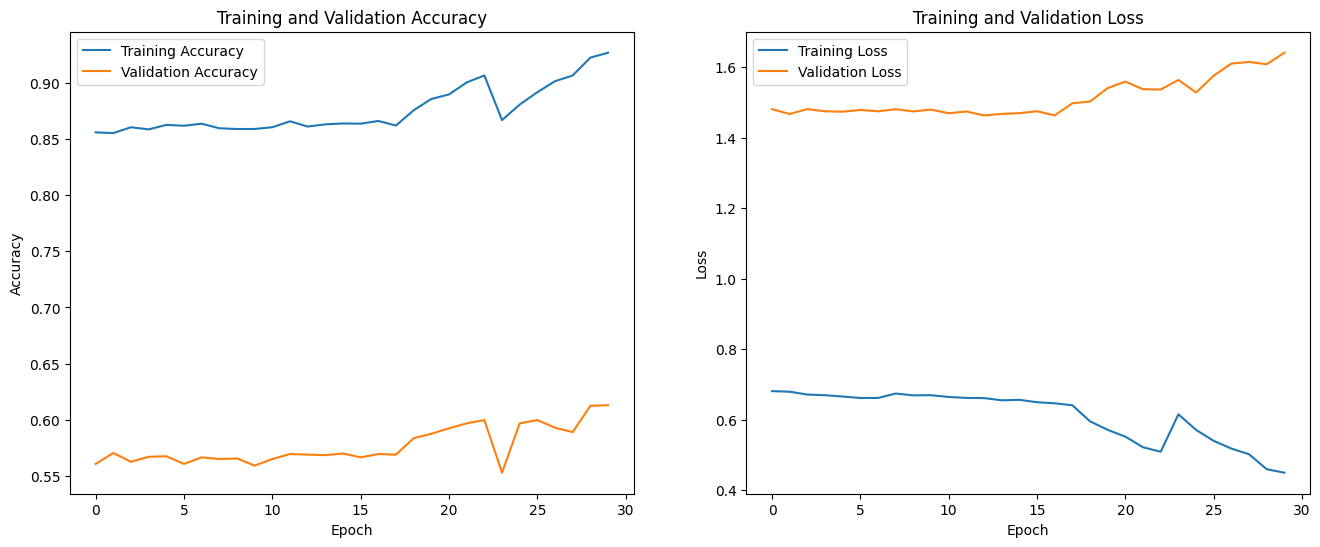

In [27]:
# Function to plot accuracy and loss
def plot_history(full_history):
    # Initialize lists for the plot
    acc, val_acc, loss, val_loss = [], [], [], []

    # Aggregate the history data
    for phase, history in full_history.items():
        acc += history['accuracy']
        val_acc += history['val_accuracy']
        loss += history['loss']
        val_loss += history['val_loss']

    # Plotting
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(full_history)


# Making Predictions


In [29]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

80/80 [==============================] - 8s 93ms/step - loss: 1.5103 - accuracy: 0.5872
Test accuracy: 58.72%


80/80 [==============================] - 8s 94ms/step - loss: 1.5103 - accuracy: 0.5872
Evaluation results: [1.5103107690811157, 0.5871774554252625]
80/80 [==============================] - 8s 95ms/step


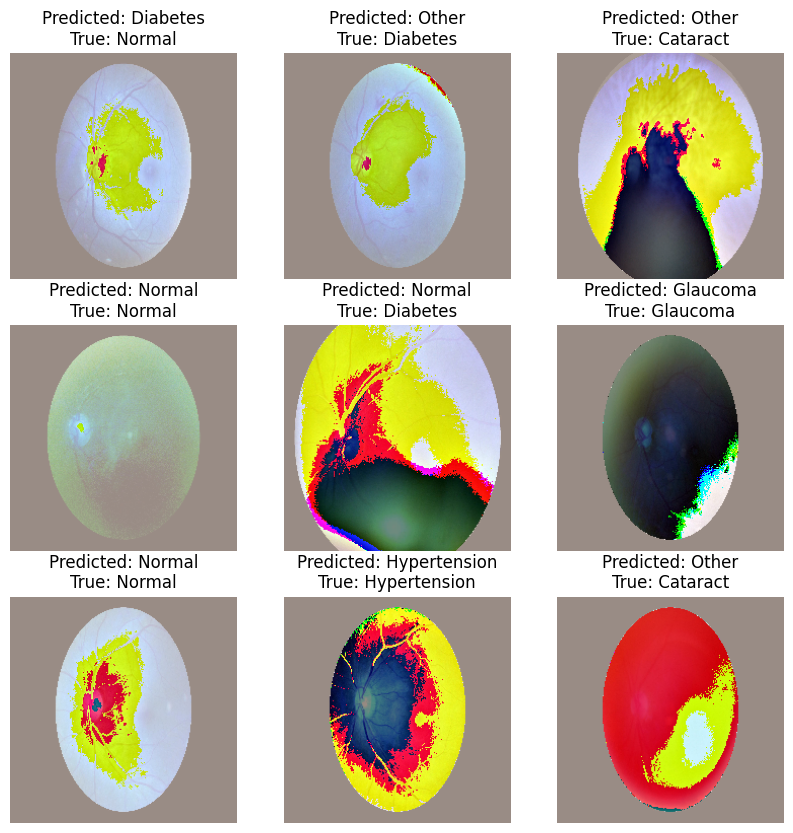

In [30]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

num_images_to_display = 9

# lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

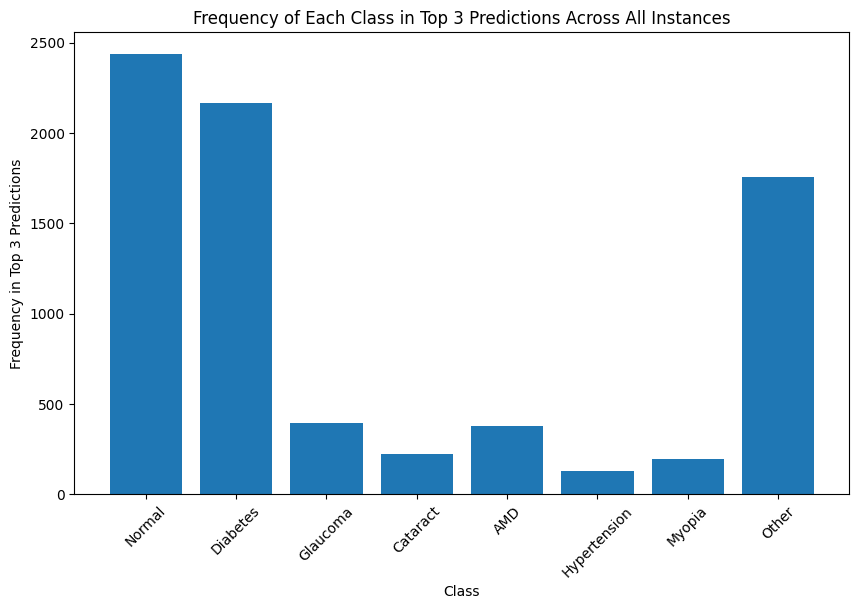

In [31]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [32]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [33]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2558, 8)


In [34]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.61      0.71      0.66      1108
      Diabetes       0.56      0.53      0.54       650
      Glaucoma       0.57      0.64      0.61       114
      Cataract       0.65      0.61      0.63       124
           AMD       0.55      0.64      0.59       100
  Hypertension       0.81      0.54      0.65        56
        Myopia       0.78      0.77      0.77       100
Other diseases       0.32      0.16      0.21       306

      accuracy                           0.59      2558
     macro avg       0.61      0.57      0.58      2558
  weighted avg       0.57      0.59      0.57      2558



Balanced Accuracy Score

In [35]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5748


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [36]:
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8507


Confusion Matrix

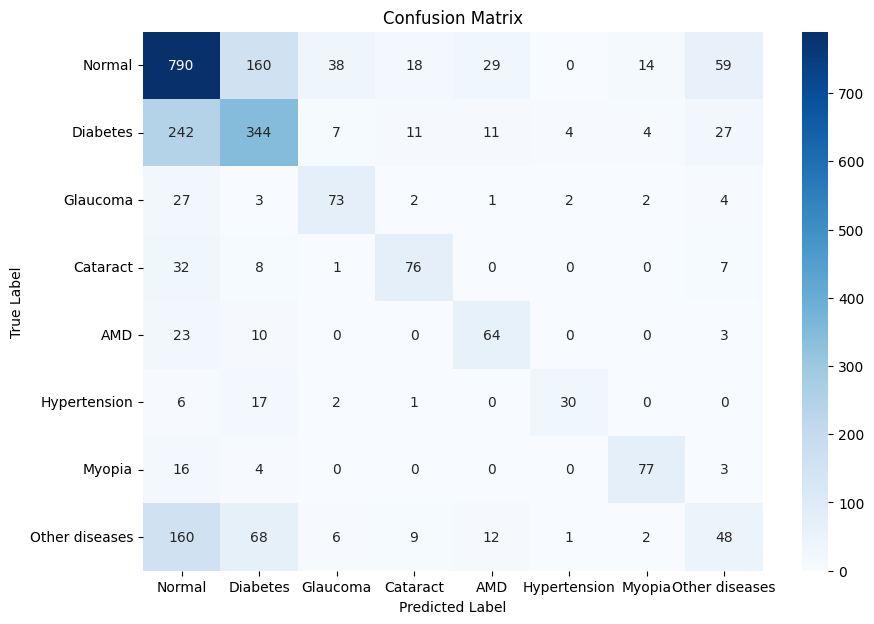

In [37]:
# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Normalised Confusion Matrix

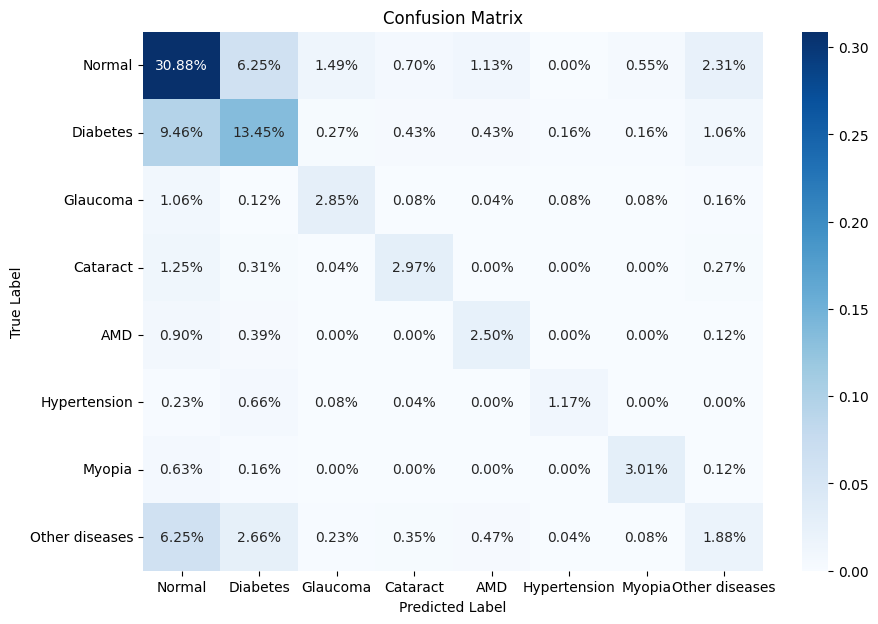

In [38]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Explainable AI
- SHAP, GradCAM, LIME

## Loading Test Images from each class for explainability

In [ ]:
test_df.head()

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
5648  3358           71      Female  3358_left.jpg  3358_right.jpg   
3257    72           78      Female    72_left.jpg    72_right.jpg   
1369  2095           76      Female  2095_left.jpg  2095_right.jpg   
2025  2888           14      Female  2888_left.jpg  2888_right.jpg   
6025  4262           60        Male  4262_left.jpg  4262_right.jpg   

                    Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  \
5648                           normal fundus             normal fundus  1  0   
3257  moderate non proliferative retinopathy       epiretinal membrane  0  1   
1369                           normal fundus                  cataract  0  0   
2025                           normal fundus             normal fundus  1  0   
6025       mild nonproliferative retinopathy         low image quality  0  1   

      G  C  A  H  M  O                                           filepath  \
5648  0  0  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...   
3257  0  0  0  0  0  1  ../input/ocular-disease-recognition-odir5k/ODI...   
1369  0  1  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...   
2025  0  0  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...   
6025  0  0  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...   

     labels                    target        filename  
5648  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]   3358_left.jpg  
3257  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]     72_left.jpg  
1369  ['C']  [0, 0, 0, 1, 0, 0, 0, 0]  2095_right.jpg  
2025  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  2888_right.jpg  
6025  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]   4262_left.jpg

### Loading at least one image from each class to be used for explainability evaluation
- These images are available on github repository and need to be uploaded to google colab temporary file storage for the code below to work. Folder is named XAI Test Images.

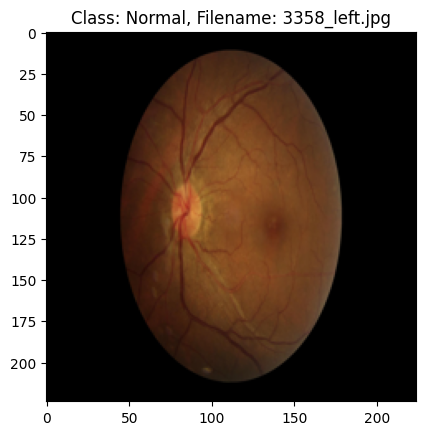

Displayed image for class "Normal": 3358_left.jpg


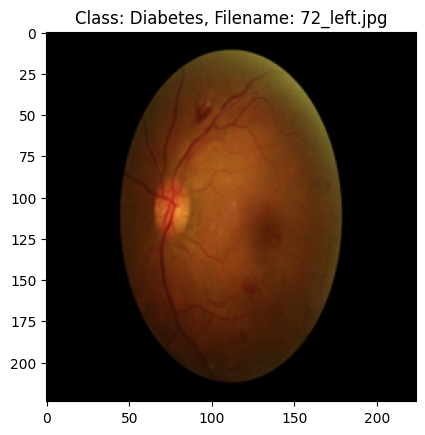

Displayed image for class "Diabetes": 72_left.jpg


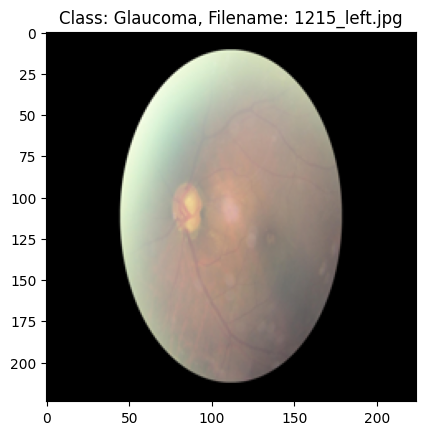

Displayed image for class "Glaucoma": 1215_left.jpg


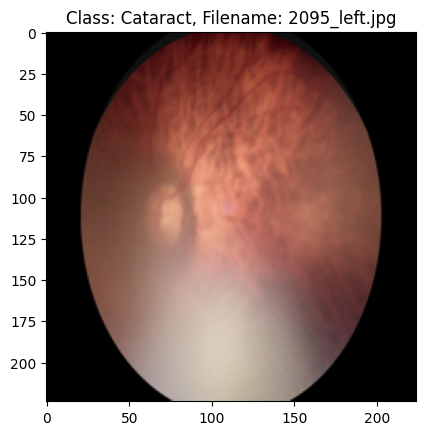

Displayed image for class "Cataract": 2095_left.jpg


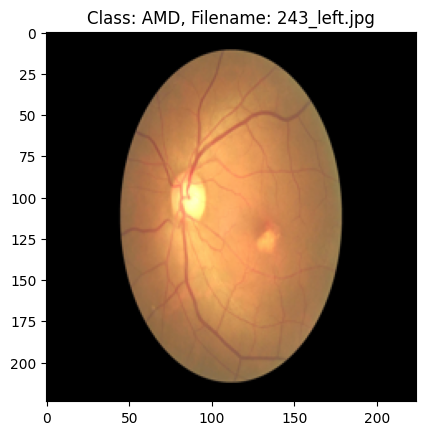

Displayed image for class "AMD": 243_left.jpg


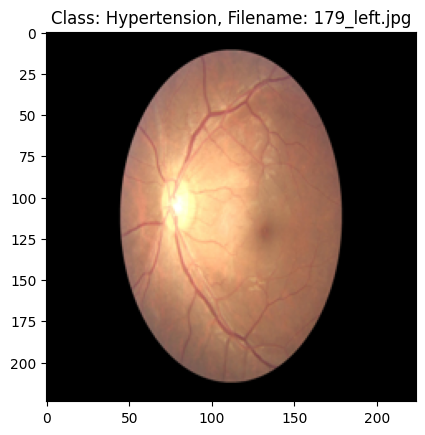

Displayed image for class "Hypertension": 179_left.jpg


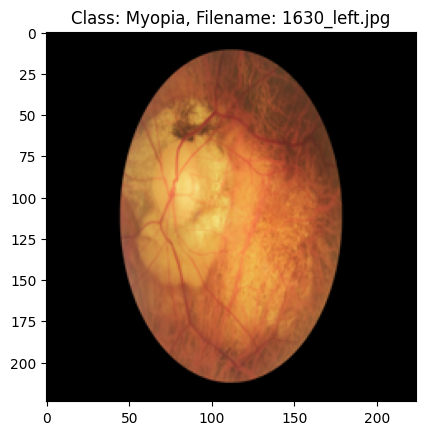

Displayed image for class "Myopia": 1630_left.jpg


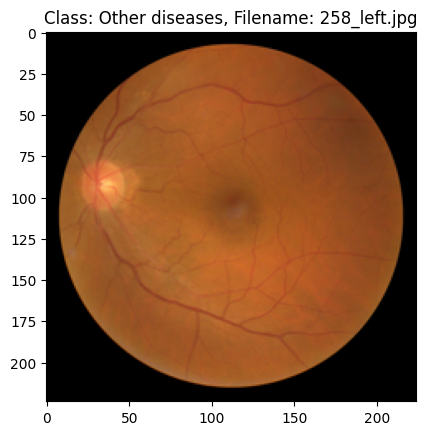

Displayed image for class "Other diseases": 258_left.jpg


In [ ]:
# Provided class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Base directory for images
images_dir = 'ODIR-5K/ODIR-5K/Training Images/'

# Function to load an image and resize it
def load_image(image_path, size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure RGB format
        img = img.resize(size)    # Resize the image
        return np.array(img)      # Convert to numpy array for display

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[np.argmax(ast.literal_eval(x))])

# Displaying one image for each class and print the filename
displayed_classes = set()

for class_name in class_labels:
    if class_name not in displayed_classes:
        # Filter the dataframe for the current class_name
        class_rows = test_df[test_df['class_name'] == class_name]
        if not class_rows.empty:
            # Take the first row for the current class_name
            row = class_rows.iloc[0]

            # Try to use the 'Left-Fundus' image if available, otherwise use the 'Right-Fundus' image
            image_path = None
            filename = None
            if pd.notnull(row['Left-Fundus']) and row['Left-Fundus']:
                image_path = images_dir + row['Left-Fundus']
                filename = row['Left-Fundus']
            elif pd.notnull(row['Right-Fundus']) and row['Right-Fundus']:
                image_path = images_dir + row['Right-Fundus']
                filename = row['Right-Fundus']

            if image_path:
                # Load and display the image with its class label
                image = load_image(image_path)
                plt.figure()
                plt.imshow(image)
                plt.title(f'Class: {class_name}, Filename: {filename}')
                plt.show()

                # Print the filename
                print(f'Displayed image for class "{class_name}": {filename}')

                # Keep track of displayed classes
                displayed_classes.add(class_name)
            else:
                print(f"No images found for class: {class_name}")
        else:
            print(f"No images found for class: {class_name}")

## Load and Process Function for all XAI methods

- There are two preprocessing function options, use the one based on the XAI method you want to run to generate images appropriate for that method.

In [39]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('best_model')

# Summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 14981448 (57.15 MB)
Trainable params: 266760 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Option 1: SHAP preprocessing function

In [55]:
def load_and_preprocess_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure RGB format
        img = img.resize((224, 224))    # Resize the image
        return np.array(img)      # Convert to numpy array for display

Option 2: GradCAM and LIME preprocessing function





In [68]:
def load_and_preprocess_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

## Generate preprocessed images
- Rerun this everytime preprocessing function is changed

In [69]:
normal = load_and_preprocess_image('Normal.jpg')
diabetes = load_and_preprocess_image('Diabetes.jpg')
glaucoma = load_and_preprocess_image('Glaucoma.jpg')
cataract = load_and_preprocess_image('Cataract.jpg')
amd = load_and_preprocess_image('AMD.jpg')
hypertension = load_and_preprocess_image('Hypertension.jpg')
myopia = load_and_preprocess_image('Myopia.jpg')
other = load_and_preprocess_image('OtherDiseases.jpg')

In [70]:
# List of preprocessed images and their labels
images = [
    ('Normal', normal),
    ('Diabetes', diabetes),
    ('Glaucoma', glaucoma),
    ('Cataract', cataract),
    ('AMD', amd),
    ('Hypertension', hypertension),
    ('Myopia', myopia),
    ('Other diseases', other)
]


##GradCAM

- Option 2 for preprocessing function

In [46]:
!pip install tf-keras-vis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.2 MB/s eta 0:00:00


In [47]:
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam

In [48]:
# Access the nested VGG16 model
vgg16_model = model.layers[0]  # Since VGG16 is the first layer of the model

# Identify the last convolutional layer in the VGG16 model
last_conv_layer_name = 'block5_conv3'

# Create a new Model up to the last convolutional layer
vgg16_submodel = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer(last_conv_layer_name).output)

In [52]:
def display_gradcam_for_all_classes(img_array, class_label, model):
    class_label_to_index = {
        'Normal': 0,
        'Diabetes': 1,
        'Glaucoma': 2,
        'Cataract': 3,
        'AMD': 4,
        'Hypertension': 5,
        'Myopia': 6,
        'Other diseases': 7
    }

    # Create GradCAM object
    gradcam = Gradcam(model, model_modifier=None, clone=False)

    # Define the score function for the desired class
    score_function = lambda output: output[:, class_label_to_index[class_label]]

    # Generate heatmap
    heatmap = gradcam(score_function, img_array, penultimate_layer=-1)[0]  # Using -1 for the last convolutional layer
    heatmap = normalize(heatmap)

    # Display original image and heatmap
    plt.figure(figsize=(5, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(img_array), cmap='viridis')  # Remove batch dimension and show
    plt.title(f'Original Image: {class_label}')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(img_array), cmap='viridis')  # Original image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.title(f'Grad-CAM: {class_label}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

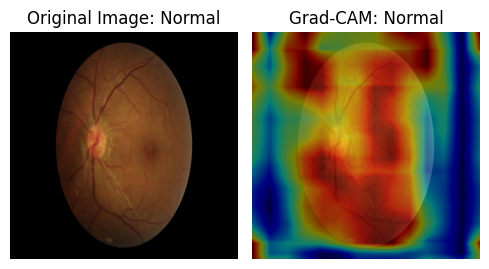

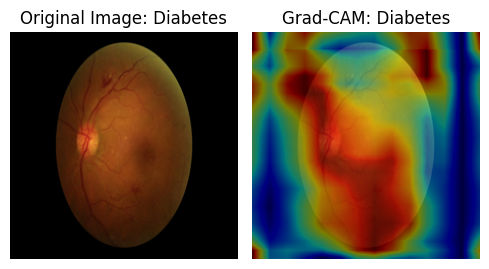

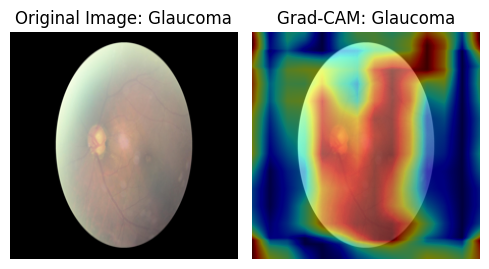

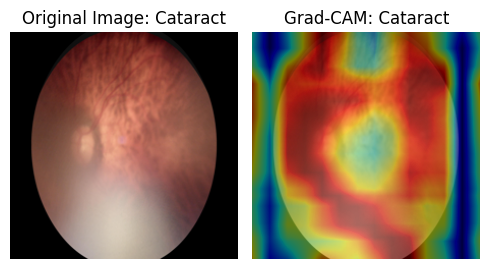

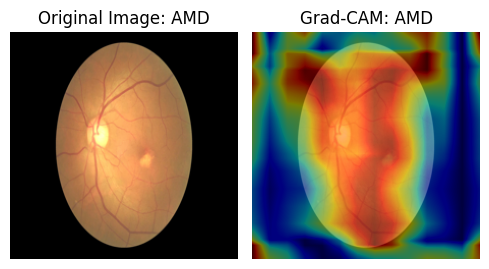

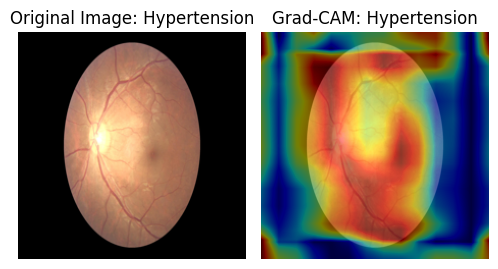

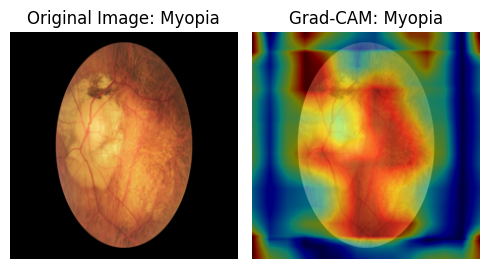

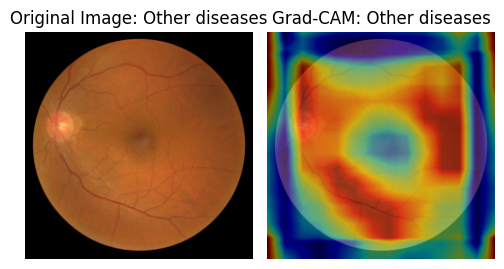

In [53]:
display_gradcam_for_all_classes(normal,'Normal', vgg16_submodel)

display_gradcam_for_all_classes(diabetes,'Diabetes', vgg16_submodel)

display_gradcam_for_all_classes(glaucoma, 'Glaucoma',vgg16_submodel)

display_gradcam_for_all_classes(cataract, 'Cataract',vgg16_submodel)

display_gradcam_for_all_classes(amd,'AMD',vgg16_submodel)

display_gradcam_for_all_classes(hypertension,'Hypertension' ,vgg16_submodel)

display_gradcam_for_all_classes(myopia, 'Myopia',vgg16_submodel)

display_gradcam_for_all_classes(other,'Other diseases',vgg16_submodel)

## SHAP
- Option 1 for preprocessing function

In [54]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.1 MB/s eta 0:00:00


In [58]:
import shap

In [59]:
# Define the prediction function
def f(x):
    return model.predict(x)
# Create the masker
masker = shap.maskers.Image("inpaint_telea", (224,224,3))

# Create the explainer
explainer = shap.Explainer(f, masker)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Define a function to compute SHAP values for a given image
def compute_shap_values(new_image):
    # Ensure the input image is in the correct format/shape for the model
    # This might include expanding the dimensions if the model expects batches
    if len(new_image.shape) == 3:
        new_image = np.expand_dims(new_image, axis=0)

    # Compute the SHAP values for the input image
    shap_values = explainer(new_image, max_evals=1000, batch_size=50)

    # Visualize the results
    shap.image_plot(shap_values, labels=class_labels)


SHAP for Normal
2/2 [==============================] - 3s 3s/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


PartitionExplainer explainer: 2it [00:40, 40.43s/it]               


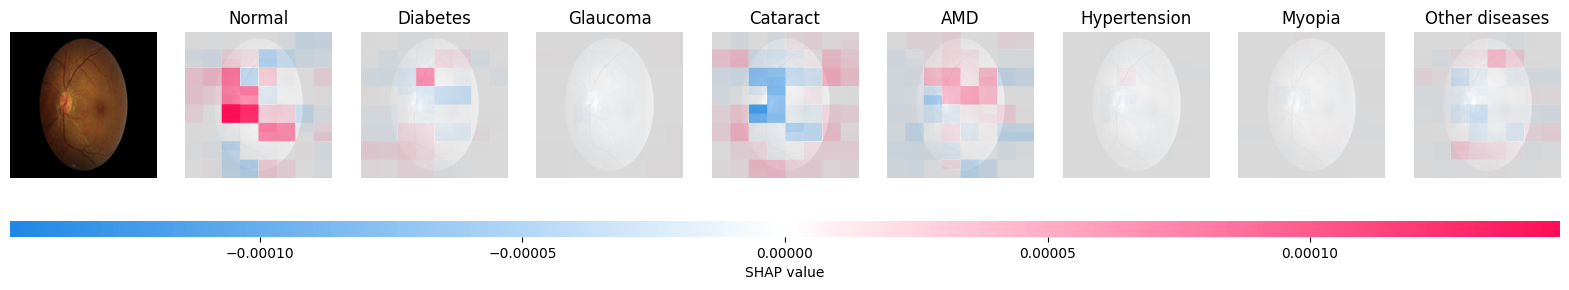

SHAP for Diabetes
2/2 [==============================] - 0s 85ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


PartitionExplainer explainer: 2it [00:30, 30.10s/it]               


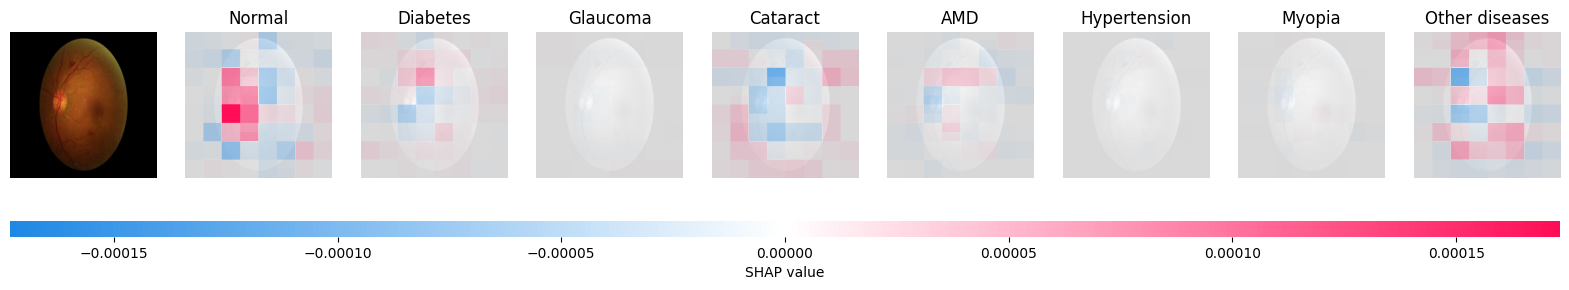

SHAP for Cataract
2/2 [==============================] - 0s 84ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


PartitionExplainer explainer: 2it [00:29, 29.04s/it]               


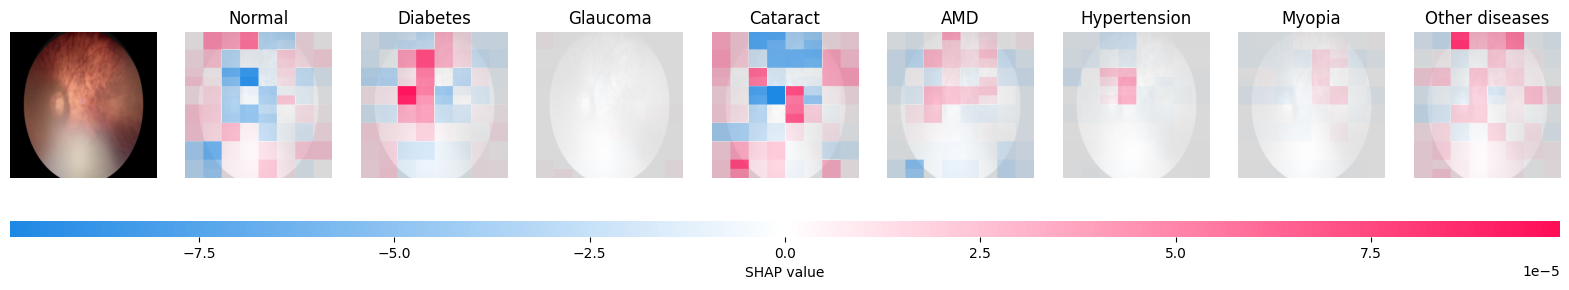

SHAP for Glaucoma
2/2 [==============================] - 0s 85ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


PartitionExplainer explainer: 2it [00:33, 33.58s/it]               


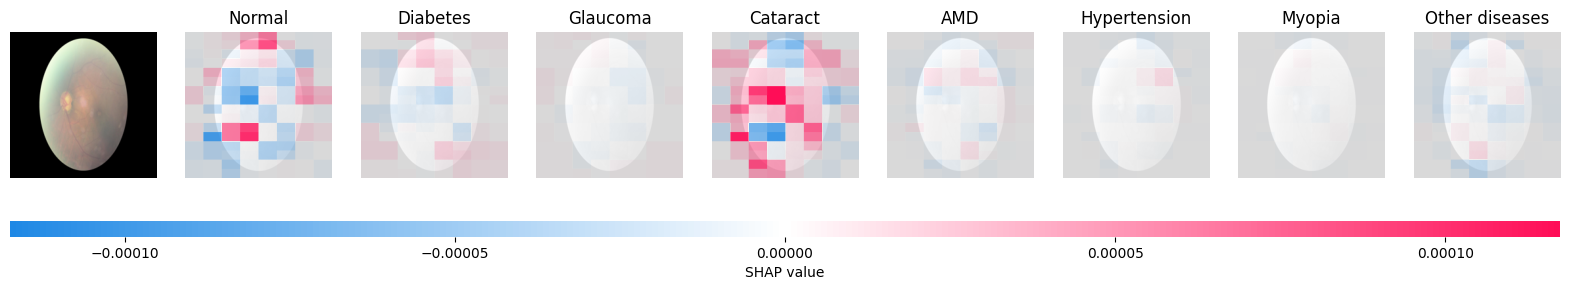

SHAP for AMD
2/2 [==============================] - 0s 84ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


PartitionExplainer explainer: 2it [00:34, 34.40s/it]               


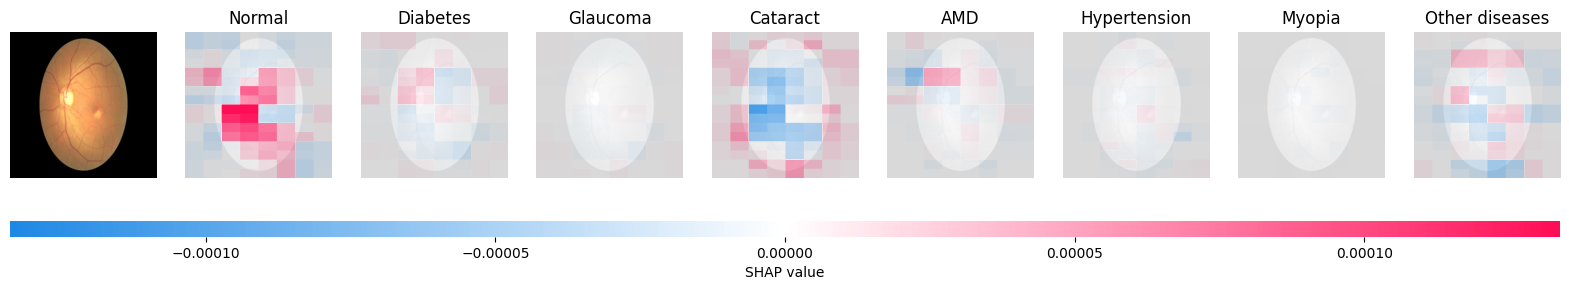

SHAP for Hypertension
2/2 [==============================] - 0s 86ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


PartitionExplainer explainer: 2it [00:30, 30.72s/it]               


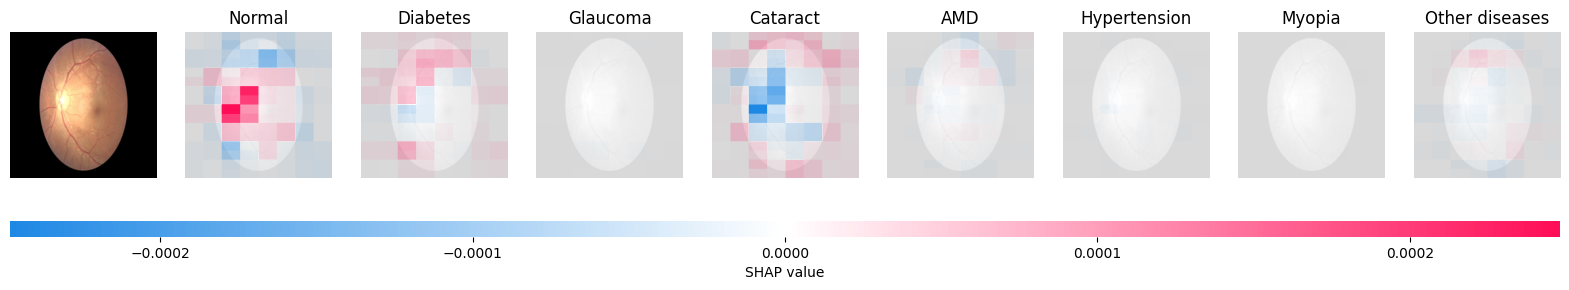

SHAP for Myopia
2/2 [==============================] - 0s 85ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


PartitionExplainer explainer: 2it [00:28, 28.33s/it]               


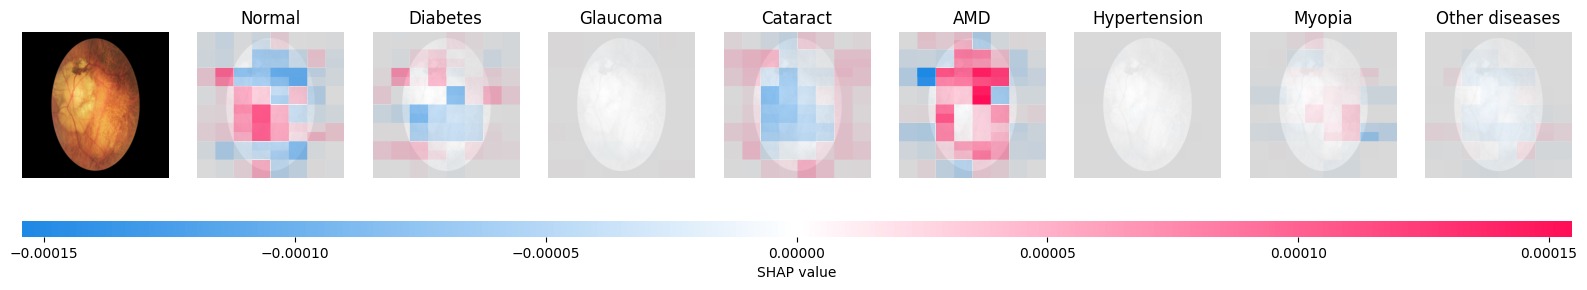

SHAP for Other Diseases
2/2 [==============================] - 0s 84ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


PartitionExplainer explainer: 2it [00:30, 30.30s/it]               


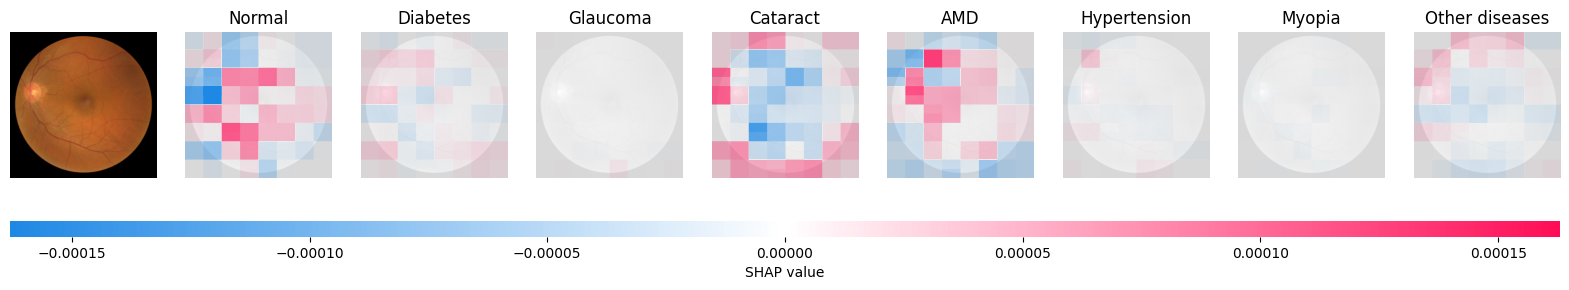

In [60]:
print("SHAP for Normal")
compute_shap_values(normal)

print("SHAP for Diabetes")
compute_shap_values(diabetes)

print("SHAP for Cataract")
compute_shap_values(cataract)

print("SHAP for Glaucoma")
compute_shap_values(glaucoma)

print("SHAP for AMD")
compute_shap_values(amd)

print("SHAP for Hypertension")
compute_shap_values(hypertension)

print("SHAP for Myopia")
compute_shap_values(myopia)

print("SHAP for Other Diseases")
compute_shap_values(other)


#Lime
- Option 2 for preprocessing function


In [61]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a586eabc5f4b330775dfc414d42f2e457180f672e6748ce80d4a25e21b573f29
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [62]:
from skimage.segmentation import mark_boundaries
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [63]:
# Map of class indices to labels
class_label_to_index = {
    'Normal': 0,
    'Diabetes': 1,
    'Glaucoma': 2,
    'Cataract': 3,
    'AMD': 4,
    'Hypertension': 5,
    'Myopia': 6,
    'Other diseases': 7
}

# Reverse the class_label_to_index dictionary to get labels from indices
index_to_class_label = {index: label for label, index in class_label_to_index.items()}

In [64]:
# Define the model_predict function
def model_predict(images):
    # This function should take an array of images as input and return predictions.
    # The exact implementation can vary based on how your model expects input.
    predictions = model.predict(images)
    return predictions


In [65]:
# Function to explain and plot an image using LIME
def explain_and_plot(image, class_label, ax):
    explanation = explainer.explain_instance(image[0], model_predict, top_labels=8, hide_color=0, num_samples=1000)

    # Normalize and prepare the image for display
    image_to_explain = image[0]
    if image_to_explain.dtype == np.float32 or image_to_explain.dtype == np.float64:
        image_to_explain /= np.max(image_to_explain)
    elif image_to_explain.dtype != np.uint8:
        image_to_explain = 255 * (image_to_explain - np.min(image_to_explain)) / (np.max(image_to_explain) - np.min(image_to_explain))
        image_to_explain = image_to_explain.astype(np.uint8)

    # Plot the original image
    ax[0].imshow(image_to_explain)
    ax[0].set_title(f'Original: {class_label}')

    # For each of the top classes, create a mask and plot it
    for i, label_index in enumerate(explanation.top_labels):
        temp, mask = explanation.get_image_and_mask(label_index, positive_only=True, num_features=5, hide_rest=False)
        ax[i + 1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        # Use the index_to_class_label dictionary to get the class name from index
        class_name = index_to_class_label.get(label_index, "Unknown")
        ax[i + 1].set_title(f'{class_name} Explanation')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


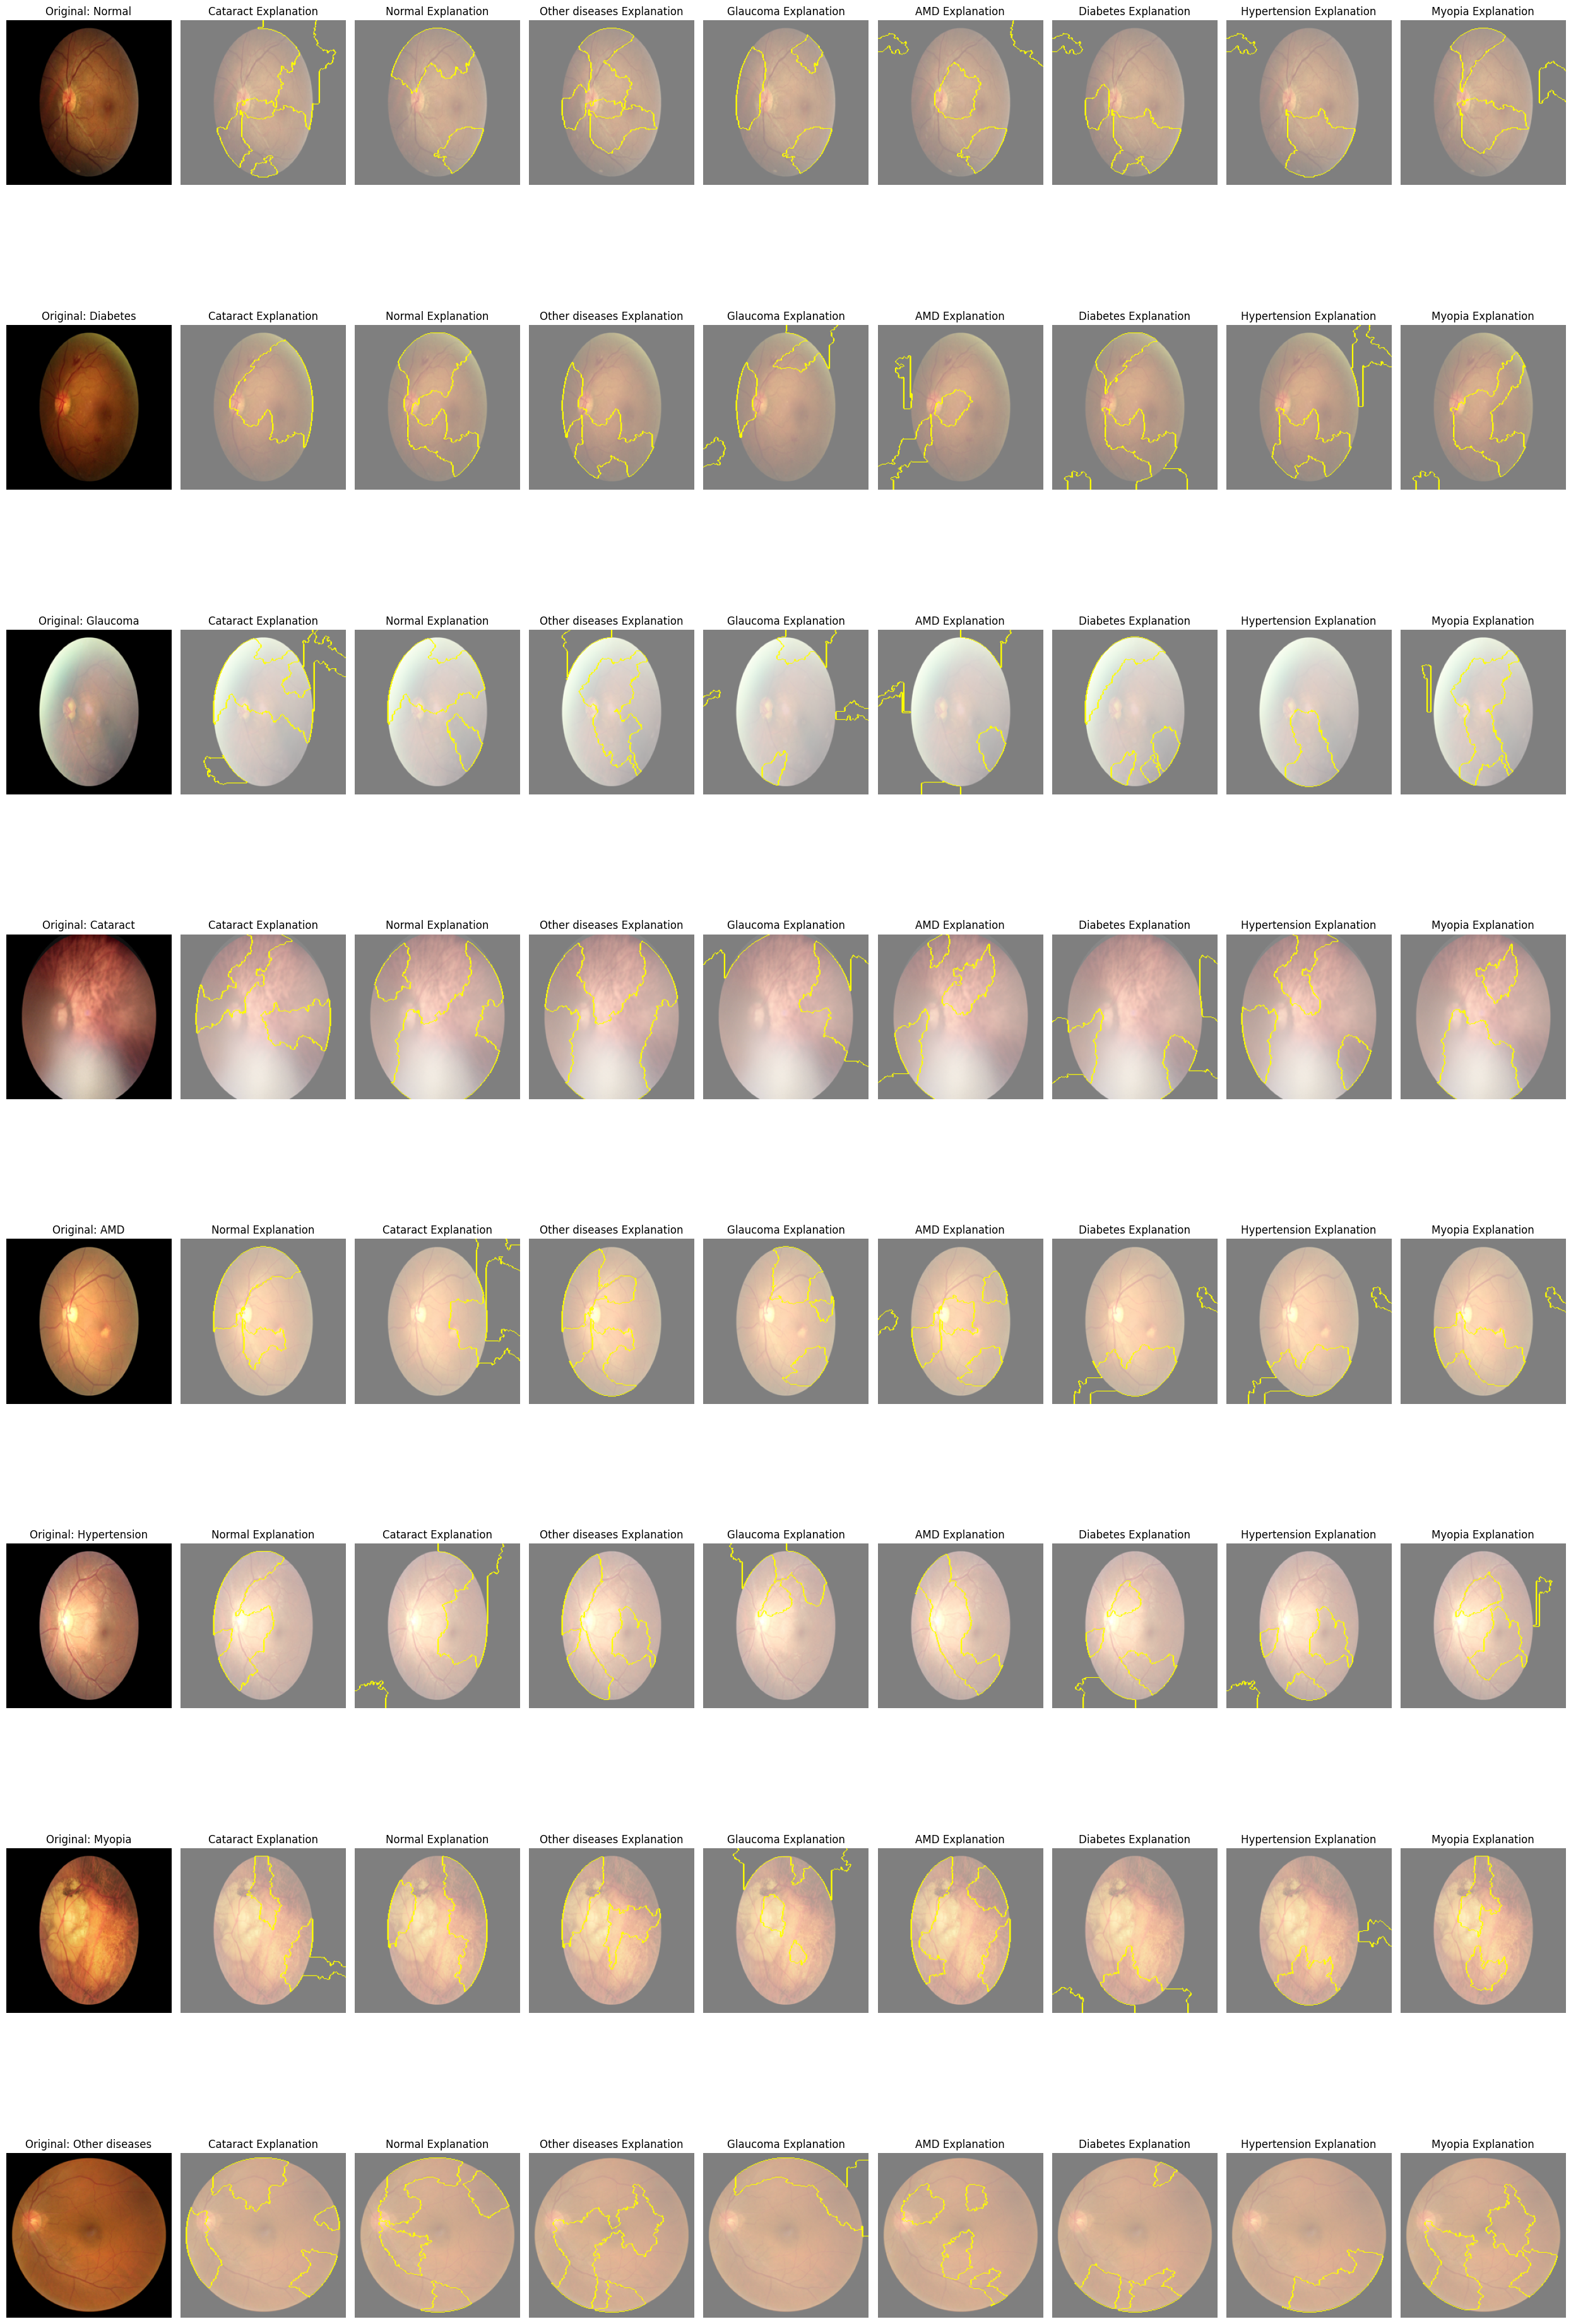

In [71]:
# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Create a figure to hold all the subplots
num_images = len(images)
fig, axes = plt.subplots(num_images, 9, figsize=(25, 5 * num_images))  # 1 column for the original image + 8 for the explanations

# Generate explanations for each image and plot
for idx, (label, image) in enumerate(images):
    explain_and_plot(image, label, axes[idx])

# Remove the axis ticks for a cleaner look and adjust layout
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
